# How FLASC works
FLASC is a clustering algorithm developed by [Bot et al](https://arxiv.org/abs/2311.15887). It extends HDBSCAN\* by adding an efficient post-processing step for detecting branches / flares within clusters. The goal of this notebook is to demonstrate how FLASC works.

In this explanation, I assume some familiarity with HDBSCAN\*. I recommend [HDBSCAN's tutorial](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) and [paper](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14) for more information about HDBSCAN\*.

## Setup
First we load a couple libraries required for running the algorithm and visualizing its steps.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from flasc import FLASC
from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

In [3]:
def soft_scatter(labels, probabilities, mask=None):
    """"A function that colors data points by their cluster membership""" 
    if mask is None:
        mask = np.ones(len(labels), dtype='bool')
    point_colors = [ 
        (0.8, 0.8, 0.8) if l < 0 else sns.desaturate(palette[l%10], p) 
        for l, p in zip(labels[mask], probabilities[mask])
    ]
    plt.scatter(data[mask, 0], data[mask, 1], 0.1, point_colors, alpha=0.5)
    plt.axis('off')

### Load Data
The data for this example is adapted from [HDBSCAN\*'s soft clustering tutorial](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html). As FLASC is designed to detect flares, we ensured this dataset contains a cluster with multiple branches.

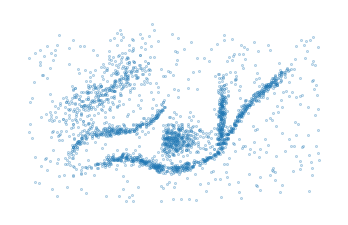

In [4]:
sized_fig()
data = np.load('./data/flared_clusterable_data.npy')
plt.scatter(data[:, 0], data[:, 1], 0.1, alpha=0.5)
plt.axis('off')
plt.show()

## Running FLASC

FLASC's interface is very similar to HDBSCAN\*. In most cases, it is sufficient to specify a *min_cluster_size* and the algorithm will detect clusters and the branches within clusters:

In [5]:
clusterer = FLASC(min_cluster_size=15).fit(data)

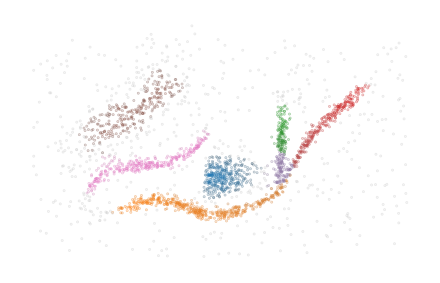

In [6]:
sized_fig()
soft_scatter(clusterer.labels_, clusterer.probabilities_)
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/teaser_flasc.png')
plt.show()

### Step 1: Detecting clusters

The first step of FLASC is running HDBSCAN\* to detect which clusters exist 
in the data. When performed successfully, this step removes noisy data points, 
simplifying the work we have to do in order to detect branches.

As expected, HDBSCAN\* sees the orange cluster with multiple branches as one 
cluster because there is a path between the branches through data points that 
lie close together.

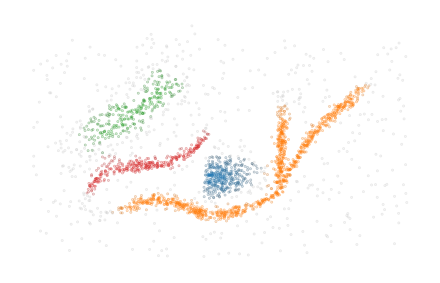

In [7]:
sized_fig()
soft_scatter(clusterer.cluster_labels_, clusterer.cluster_probabilities_)
plt.subplots_adjust(0, 0, 1, 1, 0, 0)
plt.savefig("./images/teaser_hdbscan.png")
plt.show()

The condensed tree provides more information about the clustering segmentation:

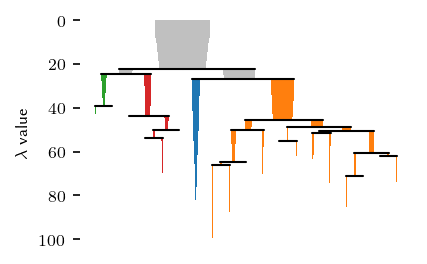

In [8]:
sized_fig()
clusterer.condensed_tree_.plot(leaf_separation=0.3)
plt.subplots_adjust(0.19, 0.05, 1, 0.95, 0, 0)
plt.show()

#### Applying a persistence threshold

By default, HDBSCAN\* does not consider the persistence of clusters. Instead it filters by cluster size and selects clusters by their stability in the resulting condensed hierarchy. Using `cluster_selection_epsilon`, it is possible to specify a minimum cluster persistence in terms of distance. Unfortunately, the condensed tree plot does not consider this value and will indicate the clusters as if no value was specified. However, you can interpret this value as a horizontal line crossing the hierarchy, indicating that only cluster above that line may exist in the final segmentation.

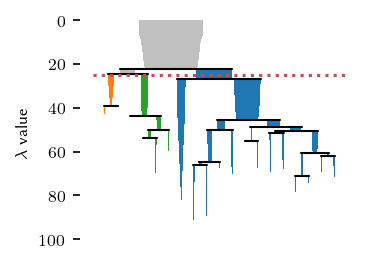

In [9]:
sized_fig()
c = FLASC(
    min_cluster_size=15, 
    cluster_selection_method='eom', 
    cluster_selection_epsilon=1/25,
).fit(data)
c.condensed_tree_.plot(leaf_separation=0.2)
plt.plot(plt.xlim(), [25, 25], 'r:')
plt.subplots_adjust(0.19,0.05,.87,.95,0,0)
plt.show()

### Step 2: Detecting branches

#### 2.1: Extract cluster approximation graph

To detect branches, FLASC looks at each cluster individually
and extracts a *cluster approximation graph*. The purpose of this graph is to
represent the cluster's *typical* connectivity, allowing us to detect branches
without having to consider the distance between data points.

FLASC supports two *branch_detection_method*s, which determine how this 
approximation graph is constructed. By default, the *full* method is used, 
which creates a graph containing all edges between data points in the cluster 
with a *mutual reachability* lower or equal to the largest distance in the cluster's 
minimum spanning tree.

The other option is the *core* method. This method is creates edges between all pairs
of points in a cluster with a mutual reachability distance lower than or equal
to one of the points' core distance. Effectively, this results in a subgraph of
the $k$-NN network over the entire data set, where $k$ is set to _min_samples_.


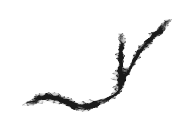

In [10]:
cluster_id = 1
sized_fig(1/5)

# Plot the points
points = clusterer.cluster_points_[cluster_id]
plt.scatter(data[points, 0], data[points, 1], 0.1, alpha=0)

# Plot the edges
mst = clusterer._cluster_approximation_graphs[cluster_id]
parents = mst.T[0].astype('int')
children = mst.T[1].astype('int')
lc = mc.LineCollection(list(zip(
    zip(data[children, 0], data[children, 1]), 
    zip(data[parents, 0], data[parents, 1])
)), linewidths=0.1, color='k', zorder=-1, alpha=0.2)
plt.gca().add_collection(lc)

plt.axis('off')
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

#### 2.2 Finding the cluster's center
As the data point distances are not enough to differentiate the branches within 
a cluster, we also compute a measure of centrality, i.e., a function that has 
high values in the center of the cluster and low values at the ends. Having a
good centrality metric is essential for detecting branches, multiple choices
can be made here. For FLASC we chose to base the centrality metric
on each point's distance to the cluster's centroid. 

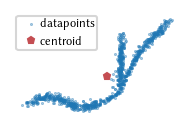

In [11]:
sized_fig(1/5)

# Draw points
plt.scatter(data[points, 0], data[points, 1], 0.2, label='datapoints', alpha=0.5)
# Draw centroid
centroid = np.average(
    data[points], weights=clusterer.cluster_probabilities_[points], axis=0
)
plt.plot(centroid[0], centroid[1], 'p', markersize=3, label='centroid', color='r')
# Draw root
plt.axis('off')
plt.legend(loc=2, borderaxespad=0.08, borderpad=0.2, handletextpad=-0.3)
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/cluster_centroid.png')
plt.show()

#### 2.3 Computing centrality function

Now, with this root point, FLASC estimates each data point's centrality as the (inverse) distance
to the cluster's centroid:

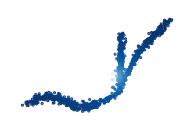

In [12]:
sized_fig(1/5)
# Draw points
centrality = clusterer.cluster_centralities_[points]
plt.scatter(data[points, 0], data[points,1], 0.2, centrality, cmap='Blues_r')
# c = plt.colorbar()
# c.set_label('centrality')
plt.axis('off')
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/cluster_centrality.png')
plt.show()

#### 2.3 Detecting branches

We can use these centrality values to detect branches as clusters in the
cluster approximation graph. The idea is to create a subset of the cluster,
using only points with a centrality lower than some threshold. Essentially,
this removes the most central part of the cluster, disconnecting the branches
and making them detectable as clusters.

By performing a filtration over the centrality (i.e., increasing the threshold
and seeing which branches combine), we can compute a full branching hierarchy.

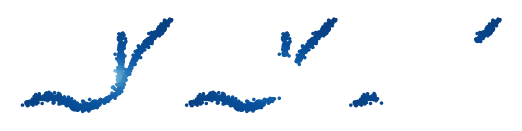

In [13]:
sized_fig(3/5, 0.618/3)
plt.subplot(1, 3, 1)
m = centrality < 20
plt.scatter(data[points[~m], 0], data[points[~m], 1], 0, alpha=0)
plt.scatter(data[points[m], 0], data[points[m], 1], 0.5, centrality[m], cmap='Blues_r', vmin=0, vmax=centrality.max())
plt.axis('off')
plt.subplot(1, 3, 2)
m = centrality < 6
plt.scatter(data[points[~m], 0], data[points[~m], 1], 0, alpha=0)
plt.scatter(data[points[m], 0], data[points[m], 1], 0.5, centrality[m], cmap='Blues_r', vmin=0, vmax=centrality.max())
plt.axis('off')
plt.subplot(1, 3, 3)
m = centrality < 3
plt.scatter(data[points[~m], 0], data[points[~m], 1], 0, alpha=0)
plt.scatter(data[points[m], 0], data[points[m], 1], 0.5, centrality[m], cmap='Blues_r', vmin=0, vmax=centrality.max())
plt.axis('off')
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

This process is a *sub-level filtration* over the centrality metric. It can also be thought of as clustering with the centrality values as 'distance'. Therefore, we apply the centrality values to the edges of the *cluster approximation graph*. Specifically, the highest centrality value of the points an edge connects is assigned to that edge. This ensures that the connection only happens when both 
points exist in a filtration.

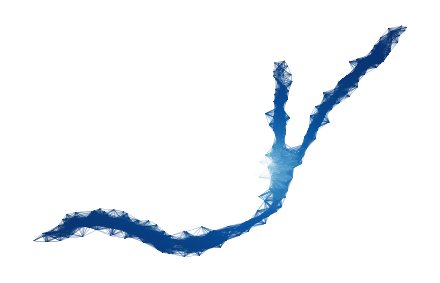

In [14]:
sized_fig()
ax = plt.gca()
graph = clusterer._cluster_approximation_graphs[cluster_id]
parents = graph[:, 0].astype('int')
children = graph[:, 1].astype('int')
lc = mc.LineCollection(list(zip(
    zip(data[parents, 0], data[parents, 1]),
    zip(data[children, 0], data[children, 1])
)), linewidths=.1, cmap='Blues_r', alpha=1)
lc.set_array(graph[:, 2])
ax.add_collection(lc)
plt.autoscale()
# c = plt.colorbar(lc)
# c.set_label("centrality")
plt.axis('off')
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

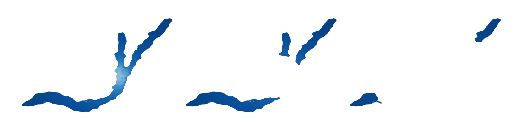

In [15]:
def show_sub_graph(threshold):
    pts = data[points]
    mask = graph.T[2] < threshold
    lc = mc.LineCollection(list(zip(
        zip(data[children[mask], 0], data[children[mask], 1]), 
        zip(data[parents[mask], 0], data[parents[mask], 1])
        )), linewidths=.5, cmap='Blues_r', zorder=-1, clim=(0, centrality.max()))
    lc.set_array(graph[mask, 2])
    plt.gca().add_collection(lc)
    plt.scatter(pts.T[0], pts.T[1], 0)
    plt.gca().add_collection(lc)
    plt.axis('off')

sized_fig(3/5, 0.618/3)
plt.subplot(1, 3, 1)
show_sub_graph(20)
plt.subplot(1, 3, 2)
show_sub_graph(6)
plt.subplot(1, 3, 3)
show_sub_graph(3)
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/branch_filtration_concept.png')
plt.show()

Effectively, we can use HDBSCAN\* to transform the *cluster centrality graph* into a single linkage hierarchy and a condensed tree to detect the branches. Note, even for clusters that do not have a branching structure, the simplified tree may contain two branches representing both sides of the cluster growing towards each other.

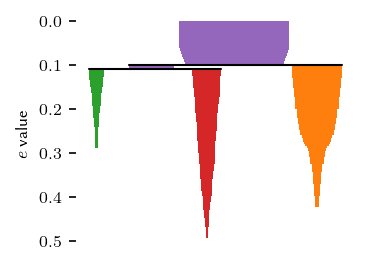

In [16]:
sized_fig()
clusterer.cluster_condensed_trees_[cluster_id].plot()
plt.ylabel("$e$ value")
plt.subplots_adjust(0.19, 0.05, 0.87, 0.95, 0, 0)
plt.show()

Similar to HDBSCAN\*, FHDBCSAN* uses a *min_branch_size* parameter to simplify the single linkage hierarchy into this condensed hierarchy. This parameter specifies a minimum size before a group is considered to be a branch. 

##### Filter by persistence

This *min_branch_size* does not correspond to persistence in the filtration, as data points can have a non-zero birth value (i.e., their centrality value). So, sometimes large branches with a low persistence are detected. These branches can be filtered out by specifying a *branch_selection_persistence*.  Again, unfortunately, the CondensedTree plot does not consider this value, so it will highlight branches as if no value was specified. But visually, this persistence value corresponds to the length branches' icicles. *Note, this is different from the condensed cluster hierarchy, where persistence is a horizontal threshold line.* The effect of this parameter will be visible in the final labelling.

#### 2.5 Flat labelling
Finally, FLASC combines the cluster and branch labels and membership probablities. This labelling needs to reflect if the cluster has branches, and which branch data points belongs to. For the probabilities, we take the average value between the cluster and branch probabilities:

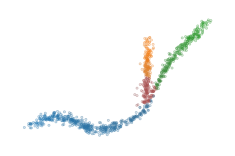

In [17]:
sized_fig(1/4)
soft_scatter(clusterer.branch_labels_, clusterer.probabilities_, points)
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/branch_labels_and_probability.png')
plt.show()

Other probability combinations, such as the probability product, are possible if desired (notice that the red cluster dissappears here, because those points have a branch probability of zero):

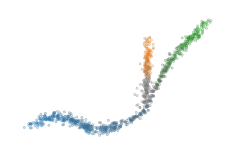

In [18]:
sized_fig(1/4)
soft_scatter(
    clusterer.branch_labels_, 
    clusterer.cluster_probabilities_ * clusterer.branch_probabilities_,
    points
)
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/branch_labels_and_probability_product.png')
plt.show()

##### Branch membership

Unlike HDBSCAN\*'s cluster probability, FLASC's branch probability are based
on the maximum eccentricity within a branch, rather than the eccentricity at 
which child-branches combine to form the selected branches in the condensed tree. This results in a more pronounced difference in probability values along a branch. 

FLASC also supports computing branch membership vectors, containing a point membership value for each branch in a cluster. These values are computed differently, by:

- Computing the weighted average point of each branch
- Finding the closest point to those centroids to act as branch root
- Computing the centrality (reverse depth) from each branch root

The data points in the center of a cluster may actually be detected as noise when comuting the branch labels. They are assigned to the 0-branch-label by default. However, these points may lie closer to another branch. For example, look at the central points when their labels are updated to the branch-label for which they have their maximum branch centrality:

In [19]:
from flasc.prediction import (
    branch_centrality_vectors, 
    update_labels_with_branch_centrality, 
)

branch_centralities = branch_centrality_vectors(clusterer)
labels, branch_labels = update_labels_with_branch_centrality(clusterer, branch_centralities)

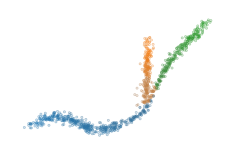

In [20]:
sized_fig(1/4)
soft_scatter(branch_labels, clusterer.probabilities_, points)
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/branch_labels_max_membership.png')
plt.show()

The branch centrality values can also be scaled to act as a membership probability: 
$$
    \mathbf{m} = \frac{
        e^{\mathbf{c} / t}
    }{
        \sum_{i}{e^{c_i / t}}
    }
$$
where $\mathbf{m}$ is the scaled membership value, $\mathbf{c}$ is a branch centrality 
vector.

To avoid adding distinct colours together, which can result in misleading color 
results, the desaturation now considers the median membership values:

In [21]:
from flasc.prediction import branch_membership_from_centrality

branch_memberships = branch_membership_from_centrality(
    branch_centralities, temperature=0.05
)

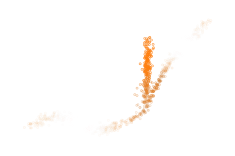

In [22]:
sized_fig(1/4)
num_branches = len(clusterer.branch_persistences_[cluster_id])
membership = branch_memberships[cluster_id]
desat = 1 - np.median(membership, axis=1)
colors = [ sns.desaturate(palette[1], d) for d in desat ]
plt.scatter(data[points, 0], data[points, 1] + 0.6, 0.05, colors, 
            alpha=membership[:, 1])
plt.axis('off')
plt.subplots_adjust(0,0,1,1,0,0)
plt.savefig('./images/branch_labels_weighted_membership.png')
plt.show()

### Additional analysis options

#### Cluster shapes
As mentioned previously, FLASC may detect two branches for clusters that do not have an obvious branching structure. These two branches represent the outside of the cluster growing inwards. Therefore, the persistence (i.e. length of the branches in the condensed diagrams) indicate how elongated a cluster is:

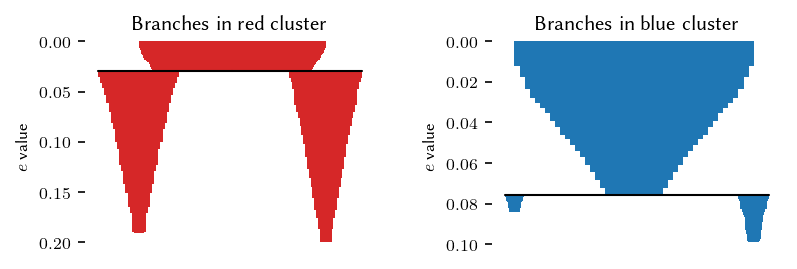

In [23]:
sized_fig(1, 0.618 / 2)
plt.subplot(1, 2, 1)
clusterer.cluster_condensed_trees_[3].plot(label_for='cluster')
plt.ylabel("$e$ value")
plt.title("Branches in red cluster")
plt.subplot(1, 2, 2)
clusterer.cluster_condensed_trees_[0].plot()
plt.ylabel("$e$ value")
plt.title("Branches in blue cluster")
plt.subplots_adjust(0.1, 0.05, 0.95, 0.88, 0.4, 0)
plt.show()

The *label_sides_as_branches* parameter can be used to also separate these branches in the data point labelling. *Note, the two shallow branches in the blue cluster are good candidates to filter with branch persistence!*

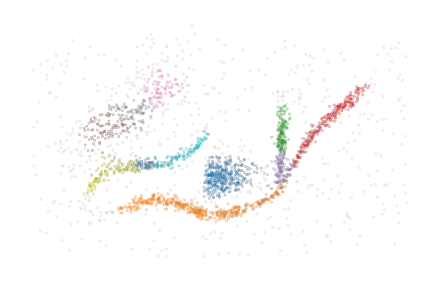

In [24]:
clusterer = FLASC(
    min_cluster_size=15,
    branch_selection_persistence=0.01,
    label_sides_as_branches=True
)
clusterer.fit(data)

sized_fig()
palette = sns.color_palette('tab10')
soft_scatter(clusterer.labels_, clusterer.probabilities_)    
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

#### Predefined clusters

The implementation is also able to work with predefined cluster labels and probabilities. In this case, the HDBSCAN\* clustering step is skipped and the given labels and probabilities are used. The clusters need not follow the density-profile because the minimum spanning trees are computed for each given cluster separately. Whether the output makes sense depends on the data and the given segmentation. When the clustering is overridden, `fhdbscan.prediction.approximate_predict` is not available

In this example below, the four clusters are merged into two clusters:

In [25]:
cluster_labels = clusterer.cluster_labels_.copy()
merged_labels = np.where(cluster_labels==1, 0, cluster_labels)
merged_labels = np.where(merged_labels==3, 1, merged_labels)
merged_labels = np.where(merged_labels==2, 1, merged_labels)

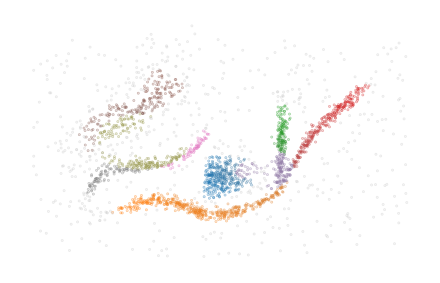

In [26]:
clusterer = FLASC(
    min_cluster_size=15,
    min_branch_size=50,
    override_cluster_labels=merged_labels,
    branch_selection_method='leaf'
).fit(data)

sized_fig()
soft_scatter(clusterer.labels_, clusterer.probabilities_)    
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

### Cluster approximation graphs

FLASC also provides functionality to draw the cluster approximation graphs.
This can be useful for high dimensional. Note that the relation between clusters
are not maintained in this layout! By default, the `ApproximationGraph`
colours nodes by their given label (supporting up to 10 colors...):

In [27]:
clusterer = FLASC(min_cluster_size=15).fit(data)
g = clusterer.cluster_approximation_graph_

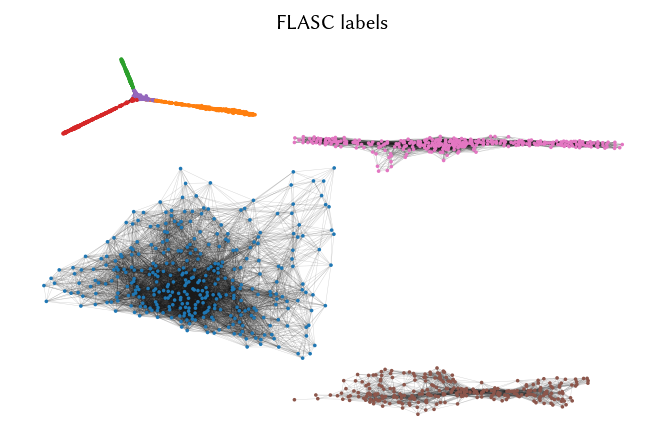

In [28]:
sized_fig(1)
g.plot(node_size=3, edge_width=0.2, edge_alpha=0.2)
plt.title('FLASC labels')
plt.show()

Other node and edge variables are accessible by their names:

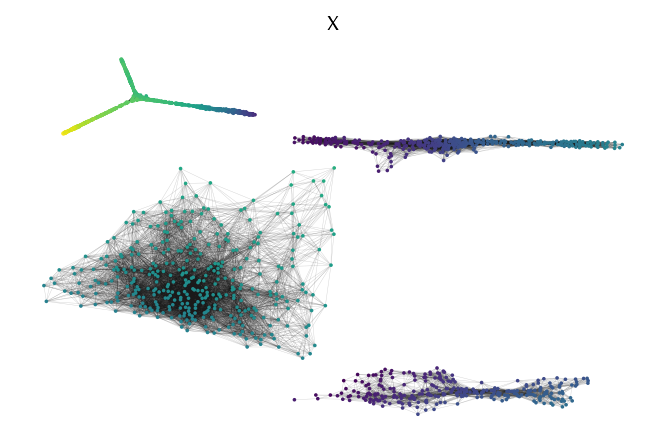

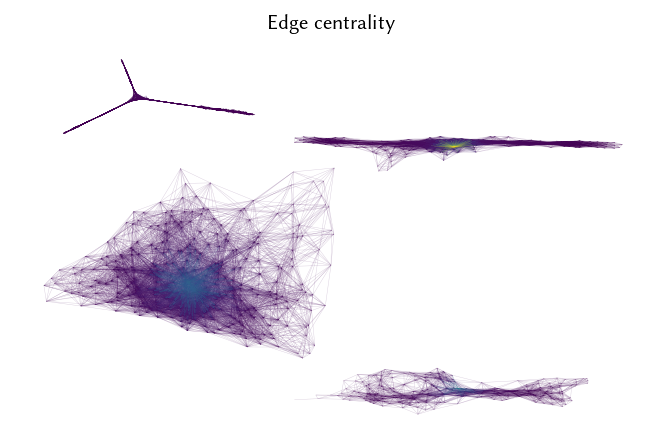

In [29]:
sized_fig(1)
g.plot(node_color='x', feature_names=['x', 'y'], node_size=3, edge_width=0.2, edge_alpha=0.2)
plt.title('X')
sized_fig(1)
g.plot(node_alpha=0, edge_color='centrality', edge_width=0.2, edge_alpha=0.2)
plt.title('Edge centrality')
plt.show()

Alternatively, it is possible to pass data to be mapped to colours directly:

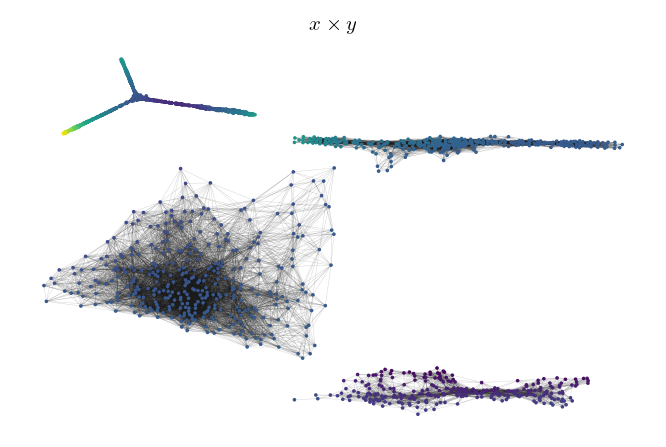

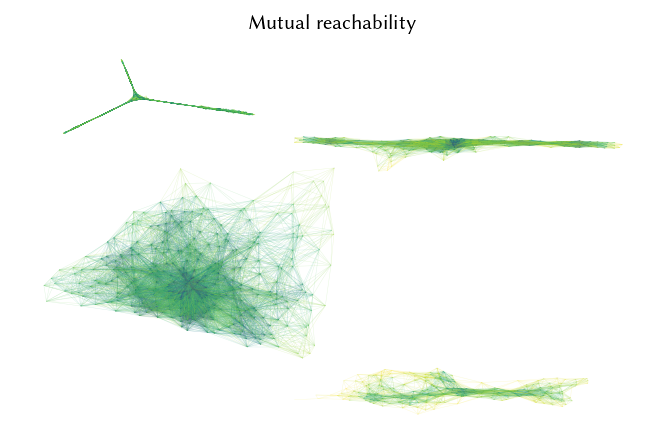

In [30]:
sized_fig(1)
g.plot(node_color=np.prod(data, axis=1), node_size=3, edge_width=0.2, edge_alpha=0.2)
plt.title('$x \\times y$')
sized_fig(1)
g.plot(edge_color=g._edges['mutual_reachability'], node_alpha=0, edge_width=0.2, edge_alpha=0.2)
plt.title('Mutual reachability')
plt.show()